# Is it a wood screw?
This is the first lecture notebook from fastai's Practical Deep Learning for Coders 2022.


https://course.fast.ai/Lessons/lesson1.html

In [1]:
%pip install -Uqq fastai duckduckgo_search

Note: you may need to restart the kernel to use updated packages.


## Step 0: Learn about the subject

* Types of wood screws: https://www.thehandymansdaughter.com/wood-screws/
* Metal vs Wood screws: https://www.finepowertools.com/woodworking/metal-screw-vs-wood-screw/

## Step 1: Gather the data

In [2]:
from pkgutil import ImpImporter
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=10):
    print(f"Searching for {term}")
    # return a list of urls
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
%time
urls = search_images('sheet metal screws', 20)
urls[0]

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.34 µs
Searching for sheet metal screws


'https://mobileimages.lowes.com/product/converted/008236/008236772258.jpg'

In [4]:
from fastai.vision.all import *
searches = 'wood','sheet-metal'
path = Path('screws')
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True,parents=True)
    download_images(dest, urls=search_images(f"{o} screws", 50))
    # resize images in-situ
    resize_images(dest, max_size=400, dest=dest)

Searching for wood screws
Searching for sheet-metal screws


In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Step 2: Train your model

Create dataloders `dls` from `path` with batch size of 32 images

In [6]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=100),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

* `blocks=(ImageBlock,CategoryBlock)` means the inputs are Images and the output are Categories ("wood", or "sheet-metal")
* `get_items=get_image_files` means use `get_image_files` function to find the input to our models
* `splitter=RandomSplitter(0.3, seed=50)` split 30% of dataset for Validation, and the rest for Training. Fixing the seed results in always generating the subsets on different runs.
* `get_y=parent_label` means the Y-value of any image is in the name of the parent folder
* `item_tfms=[Resize(192, method='squish')]` means resize each image to 192x192 pixels by squishing it (not cropping), before training
* `dataloaders(path, bs=32)` load data form `path` and create batches of 32 images each


Now learn using `resnet18`

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.587666,0.060016,0.011696,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.124637,0.006489,0.000000,00:24
1,0.079164,0.001031,0.000000,00:28
2,0.058094,0.000893,0.000000,00:31
3,0.040717,0.000207,0.000000,00:33
4,0.028081,0.000109,0.000000,00:31
5,0.024064,0.000015,0.000000,00:31
6,0.016451,0.000028,0.000000,00:32
7,0.015538,0.000018,0.000000,00:29
8,0.010138,0.000020,0.000000,00:31
9,0.008291,0.000026,0.000000,00:32


View confusion matrix:

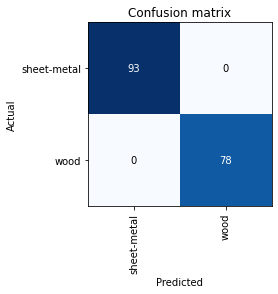

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

See images with highest loss:

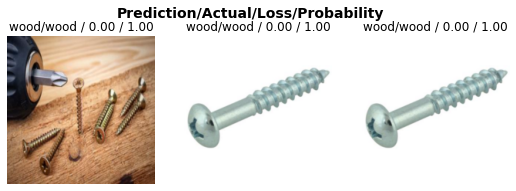

In [9]:
interp.plot_top_losses(3, nrows=1)

## Step 3: Use your model